# Reachability Deficits in Quantum Approximate Optimization

## 项目介绍

命题逻辑的可满足性问题（SAT）是计算机科学中的核心问题。最大可满足问题（Max-SAT）是 SAT 问题的一个自然的扩展。对于给定的 CNF 公式， Max-SAT 问题的目标是找到一个赋值使其满足最多的析取子句。 Max-SAT 是一个重要的NP-难优化问题。由于人工智能、电路自动设计、统计物理、生物信息学等领域的许多问题都可以转化为 Max-SAT 问题，所以近十年来， Max-SAT 问题引起了越来越多的兴趣和关注。

而量子近似优化算法（QAOA）也已迅速成为当代量子计算算法发展的基石。但尽管其应用范围不断扩大，却只有少数研究结果有助于理解该算法的最终局限性。本文发现，当给定近似精度时，与高密度的实例相比，低子句密度的实例所需的 QAOA 电路深度更少。若将临界的 QAOA 深度视为计算成本，电路深度的增加就类似于经典 MAX-SAT 求解器计算资源的需求增加，此时求解器的性能（最佳可能近似值）也会更好。不过，尽管增加深度可以获得更好的近似值，但若固定 QAOA 的深度，其性能（最佳可能近似值）对问题密度 α 的依赖性并不平凡。

本实验以变量数 n=6 的 Max-SAT 为例，对于子句密度 α 从 0 至 10 ，随机各产生 100 组合取范式，调用 QAOA 进行优化，并将结果与实际答案计算误差并作图，很好地说明了目标结论。

# 复现过程
## 安装最新版Minduantum


## 导入相关依赖

In [1]:
from mindquantum.core import Circuit, Hamiltonian, QubitOperator
from mindquantum.core import UN, H, X, RZ, RX
from mindquantum import ParameterResolver as PR
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import mindspore as ms
import mindspore.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random

[WARNING] ME(142496:139840314537280,MainProcess):2023-10-17-15:18:58.898.116 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


## 随机生成合取范式

对于合取范式中的 m 条析取子句，首先用`random.sample`从 n 个变量中随机选取 k 个（k-SAT问题），再对它们各随机一个 0 或 1 表示对应变量为假或真时不满足条件。当一个析取子句中全部变量均不满足时，意为这个析取子句未被满足，在后文中会产生 1 单位能量作为罚分 penalty 。

In [2]:
def random_clauses(n,m,k=3):
    s = []
    for i in range(m):
        l = random.sample(range(n), k)
        for j in range(k):
            t = random.randint(0, 1)
            l[j] += t * n
        s += [tuple(l)]
    return s

## 经典方法计算实际最小值

由于哈密尔顿量为一个对角矩阵，因此只需统计对角线上最小值，即对于 n 个变量的 $2^n$ 种取值分别计算罚分 penalty，最小值即为最小的未被满足的子句个数。

In [3]:
def calc_minV(n,s,output=False):
    if output:
        print("Perfect answers:")
    ans = len(s)
    for cas in range(1<<n):
        penalty = 0
        for l in s:
            satsfied = False
            for x in l:
                if x < n and cas & (1<<x) != 0 :
                    satsfied = True
                if x >= n and cas & (1<<(x-n)) == 0 :
                    satsfied = True
            if not satsfied :
                penalty += 1
        if penalty == 0 and output:
            print("  {:0>6}".format(str(bin(cas))[2:]))
        ans = min(ans, penalty)
    return ans

## 搭建量子参数线路

这里我们采用量子绝热近似算法，经过演化将量子态从 $X^{\otimes n}$ 的本征态 $|+\rangle ^{\otimes n} $ 演化到合取范式对应哈密尔顿量的基态。

深度为 p 的线路将有 2p 个参数待优化。

In [4]:
def build_ansatz(n,s,p):
    c = UN(H, n)                  # 将|0>生成均匀态
    for i in range(p):
        c += build_Ug(n, s, i)    # 搭建对应哈密顿量的含时演化线路
        c += build_Ub(n, i)       # 搭建 X^n 的含时演化线路
    return c

### 搭建对应哈密顿量的含时演化线路：

In [5]:
def build_Ug(n,s,d,k=3):
    gd = f'g{d}'
    c = Circuit()
    for l in s:
        # 0 ~ n-1  means penalty on 0 (needed flipping)
        # n ~ 2n-1 means penalty on 1
        for x in l:
            if x < n:
                c += X.on(x)
        ll = [x%n for x in l]
        for j in range(k):
            c += RZ(PR({gd: 0.5**j})).on(ll[k-1-j], ll[:k-1-j])
        for x in l:
            if x < n:
                c += X.on(x)
    return c

### 搭建 $X^{\otimes n}$ 的含时演化线路：

In [6]:
def build_Ub(n,d):
    bd = f'b{d}'
    c = Circuit()
    for i in range(n):
        c += RX(bd).on(i)
    return c

## 构建对应的哈密顿量

In [7]:
def build_ham(n,s):
    ham = QubitOperator()
    for l in s:
        mono = QubitOperator('')
        for x in l:
            mono *= (QubitOperator('') + QubitOperator(f'Z{x%n}', (-1)**(x//n))) / 2
        ham += mono
    return ham

## 搭建待训练的神经网络
由于该问题不需要编码层量子线路，我们这里使用MindQuantumAnsatzOnlyLayer作为待训练的量子神经网络，并采用Adam优化器。

以下使用深度 p=15 ，变量数 n=6 ，析取子句数 m=25 时的情况作为演示实例，随机种子依复现要求设置为 42。

In [8]:
random.seed(42)
p = 15
n = 6
m = 25
s = random_clauses(n, m)
print("s=",s)
minV = calc_minV(n, s, True)
ham = Hamiltonian(build_ham(n, s))
circ = build_ansatz(n, s, p)
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
sim = Simulator('mqvector', n)
grad_ops = sim.get_expectation_with_grad(ham, circ)

s= [(11, 0, 4), (7, 0, 4), (0, 1, 10), (1, 3, 8), (2, 11, 1), (6, 9, 11), (6, 3, 11), (5, 4, 2), (5, 1, 2), (9, 2, 11), (2, 1, 5), (7, 3, 10), (6, 7, 11), (0, 7, 8), (11, 3, 1), (11, 10, 8), (1, 5, 3), (1, 11, 9), (4, 3, 8), (11, 8, 0), (3, 0, 8), (5, 10, 1), (10, 11, 0), (0, 2, 4), (10, 0, 5)]
Perfect answers:
  001100
  001101
  001111
  011011
  011111


## 对神经网络进行训练

### 使得训练次数与线路深度 p 成正比的训练方案：

In [9]:
net = MQAnsatzOnlyLayer(grad_ops)
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)
train_net = nn.TrainOneStepCell(net, opti)
err = train_net().asnumpy()[0]
for __ in range(p//2):
    err = min(err, train_net().asnumpy()[0])
    print("error =", err-minV)
err -= minV
pr = dict(zip(circ.params_name, net.weight.asnumpy()))
state = circ.get_qs(pr=pr, ket=True)
print("\nThe Best Parameters:", state, sep='\n')

error = 2.6135623455047607
error = 1.8536348342895508
error = 1.2705696821212769
error = 1.0467946529388428
error = 1.0467946529388428
error = 0.8731071949005127
error = 0.6877385377883911

The Best Parameters:
(-0.003800812751574335-0.03292389933193925j)¦000000⟩
(-0.013479754682746524-0.0240747175888959j)¦000001⟩
(-0.017482729041334005-0.011594582465241332j)¦000010⟩
(-0.16452589449888294+0.09680054680065624j)¦000011⟩
(-0.03731001602478453-0.03404519674769549j)¦000100⟩
(-0.06970943459226375-0.08449624286606718j)¦000101⟩
(-0.03531310685033902-0.034123622477014615j)¦000110⟩
(-0.14588884551412507-0.06550398574825596j)¦000111⟩
(-0.03318545311966-0.032637874856762415j)¦001000⟩
(-0.04711541874597405-0.09723292932001278j)¦001001⟩
(-0.03494458335796749-0.033758183052172035j)¦001010⟩
(-0.23172533081400534-0.09978475497573133j)¦001011⟩
(-0.0929646259317471+0.05813668015110448j)¦001100⟩
(-0.28057595194017276-0.013475516093823123j)¦001101⟩
(-0.03825784794173871-0.08308373175241772j)¦001110⟩
(-0.43

### 不断训练直至收敛的训练方案：

In [10]:
net = MQAnsatzOnlyLayer(grad_ops)
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)
train_net = nn.TrainOneStepCell(net, opti)
lst = train_net().asnumpy()[0]
while True:
    err = train_net().asnumpy()[0]
    print("error =", err-minV)
    if lst > err and lst - err < 0.001 :
        break
    lst = min(lst, err)
err -= minV
pr = dict(zip(circ.params_name, net.weight.asnumpy()))
state = circ.get_qs(pr=pr, ket=True)
print("\nThe Best Parameters:", state, sep='\n')

error = 2.8112621307373047
error = 1.6182968616485596
error = 1.1701784133911133
error = 1.214866042137146
error = 1.431679368019104
error = 1.5053266286849976
error = 1.4055665731430054
error = 1.1724367141723633
error = 0.8564793467521667
error = 0.5668161511421204
error = 0.4785301387310028
error = 0.6034889817237854
error = 0.6782981753349304
error = 0.5848295092582703
error = 0.4373302161693573
error = 0.3556373417377472
error = 0.34338614344596863
error = 0.3527950346469879
error = 0.3560943901538849
error = 0.3419099748134613
error = 0.30849823355674744
error = 0.2696271240711212
error = 0.24387051165103912
error = 0.23714901506900787
error = 0.24091731011867523
error = 0.24052539467811584
error = 0.22637012600898743
error = 0.20116227865219116
error = 0.17715586721897125
error = 0.16549459099769592
error = 0.16651128232479095
error = 0.1696980595588684
error = 0.16372154653072357
error = 0.14674954116344452
error = 0.12746624648571014
error = 0.11657681316137314
error = 0.11693

## 对最终结果作图验证


The largest amplitude is on |001111>



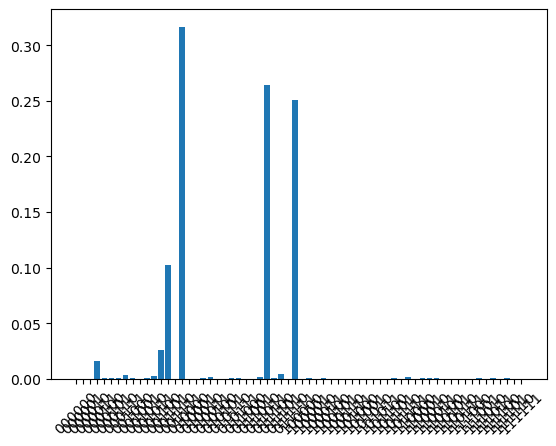

In [11]:
import matplotlib.pyplot as plt
def show_amp(amp):
    n_qubits = int(np.log2(len(amp)))
    labels = [bin(i)[2:].zfill(n_qubits) for i in range(len(amp))]
    plt.bar(labels, amp)
    plt.xticks(rotation=45)
    plt.show()

state = circ.get_qs(pr=pr)
amp = np.abs(state)**2
print(f"\nThe largest amplitude is on |{bin(np.argmax(amp))[2:]:0>6}>\n")
show_amp(amp)

# 统计结果

原文章中其实并未提及其 QAOA 具体实现细节，因此在本次复现过程中，笔者尝试了四种迭代调用神经网络的方案：

### 固定地调用一定次数

由于更深的电路有更多的参数待优化，因此适合较浅电路的迭代次数并不适合较深电路，会导致较深电路由于未开始收敛而表现较差，没有研究意义。由于在笔者采样初期便发现了这一情况，故没有消耗算力将具体图像做出。



### 调用次数与电路深度 p 正比例相关（`max_3_sat_p.py`）

由于更深的电路有更多的参数待优化，因此应该也需要更多的迭代次数才能收敛。

当调用次数为 $\lceil \frac{p}2 \rceil$ 时，对每组 (p,n,m) 随机取样 100 次得到的误差棒图如下：

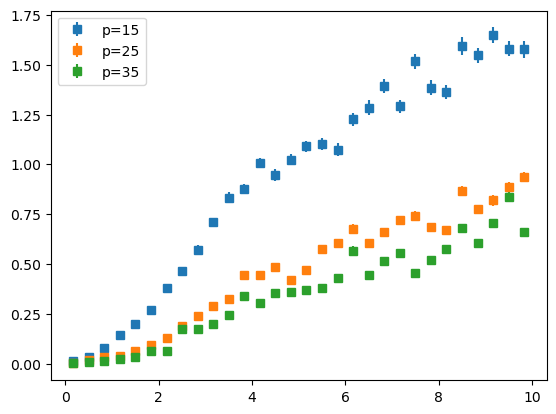

In [12]:
from src.show import show_all_p
show_all_p()

本图是与论文原文最接近的一张图。

可以看出，**随着子句密度的增加，三种电路深度的 QAOA 与标准答案的误差值均在增加，且与子句密度 α 的依赖关系并不平凡**。

同时，在此图中也可以看出，**电路深度的增加有助于减少误差值，得到更接近实际最优值的答案**。


### 调用次数与电路深度 p 和子句密度 α 均正相关（`max_3_sat_pa.py`）

由于 α 表征了解决问题的难度，即 α 越大，在解空间中寻找最优解越难，因此笔者也尝试了将 α 考虑进迭代次数。

当 α 取值从 0 到 10 变化时，希望其迭代次数在 $\lceil \frac p2 \rceil$ 基础上乘以一个从 1 到 1.5 变化的因子，
此时调用次数为 $ \lceil \frac p2 \times (1+ \frac{\alpha}{20})\rceil$ 。

对每组 (p,n,m) 随机取样 100 次得到的误差棒图如下：

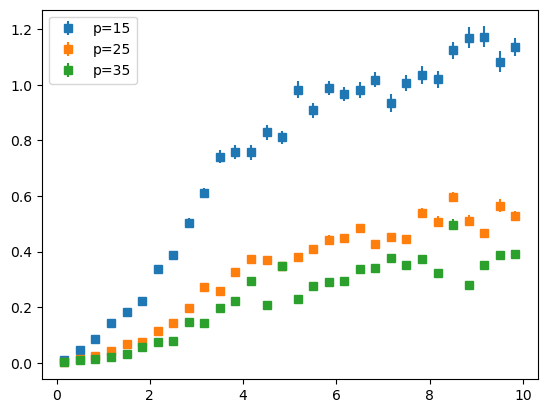

In [13]:
from src.show import show_all_pa
show_all_pa()

在本图中，对于固定深度的 QAOA 电路，其误差值随子句密度的变化较前一种方案更为波动。

但依然可以看出，**电路深度的增加有助于减少误差值，得到更接近实际最优值的答案**。

### 不断训练直至收敛（`max_3_sat_conv.py`）

如前文实例代码所示，此种方案通常需要较多的迭代次数，实在过于消耗算力（估计全部采样完成需要上百小时），因此没有具体对所有 (p,n,m) 均做 100 次采样。但就笔者对部分 m 的取值采样结果来看，电路深度对最佳可能近似值的影响非常小，猜测或许是由于该哈密顿算子作为对角矩阵所具有的线性性质导致。

在此种方案下，**结果误差远小于原论文中误差**，并且能够全部小于 1。

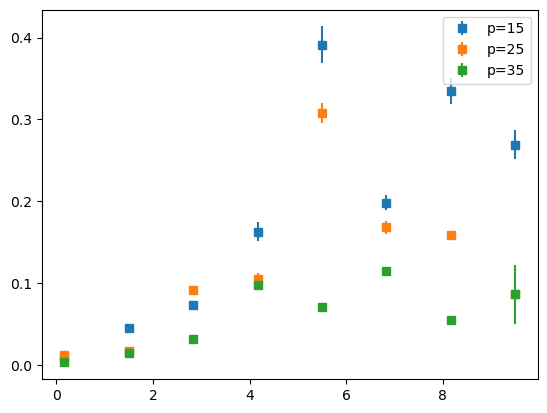

In [14]:
from src.show import show_all_conv
show_all_conv()

# 总结

本次复现中，不仅达到了与论文原图较为贴近的效果，还同时设计了多种迭代方案也得到了相近的结论。另外，笔者认为，由于我们的 Max-SAT 问题背景已经决定了**最优结果必为整数**，所以在此先验知识下，调用者完全可以采用 QAOA 优化得到的最优值向下取整作为实际答案。若采用`max_3_sat_conv.py`迭代直至收敛的方案，则在取样中 QAOA 优化得到的最优值与实际最优值之差**完全小于 1** ，即向下取整完全可以得到正确答案，相比原论文中误差可能大于 1 的情形，其优化效果是从量变到质变的。